In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os

In [2]:
os.getcwd()

'c:\\Git\\GitHub\\DSF2024_Project'

# Weather Data

In [3]:
#Import weather data and drop utc timezone
weather = pd.read_csv("data/weather.csv")
weather.drop(columns = "timestamp_utc", inplace = True)
#Rename timestamp_cet feature into Timestamp
weather.rename(columns = {"timestamp_cet": 'Timestamp'}, inplace = True)
#Show data
weather

Timestamp  air_temperature  water_temperature  \
0       2007-04-22T21:20:00+02:00             18.9               15.2   
1       2007-04-22T21:30:00+02:00             18.1               15.2   
2       2007-04-22T21:40:00+02:00             17.7               15.1   
3       2007-04-22T21:50:00+02:00             17.6               15.3   
4       2007-04-22T22:00:00+02:00             17.4               15.4   
...                           ...              ...                ...   
909575  2024-11-18T15:30:00+01:00             10.9               11.7   
909576  2024-11-18T15:40:00+01:00             10.8               11.7   
909577  2024-11-18T15:50:00+01:00             10.6               11.7   
909578  2024-11-18T16:00:00+01:00             10.5               11.7   
909579  2024-11-18T16:10:00+01:00             10.4               11.7   

        wind_gust_max_10min  wind_speed_avg_10min  wind_force_avg_10min  \
0                       1.6                   0.7                   0.7   
1                       1.3                   0.8                   0.8   
2                       0.9                   0.2                   0.2   
3                       0.6                   0.1                   0.1   
4                       0.7                   0.3                   0.3   
...                     ...                   ...                   ...   
909575                  4.2                   1.7                   1.7   
909576                  4.5                   1.9                   1.9   
909577                  4.8                   1.7                   1.7   
909578                  4.3                   1.1                   1.1   
909579                  4.9                   0.6                   0.6   

        wind_direction  windchill  barometric_pressure_qfe  precipitation  \
0                  321       18.9                    973.5            0.0   
1                  346       18.1                    973.7            0.0   
2                    4       17.7                    973.7            0.0   
3                  235       17.6                    973.8            0.0   
4                  178       17.4                    973.9            0.0   
...                ...        ...                      ...            ...   
909575             213        9.4                    968.9            0.0   
909576             281        9.2                    968.9            0.0   
909577             272        8.9                    968.9            0.0   
909578             274        9.4                    968.9            0.0   
909579             156        9.1                    968.8            0.0   

        dew_point  global_radiation  humidity  water_level  
0             4.4               3.0      38.0       405.94  
1             4.8               3.0      41.0       405.94  
2             5.1               3.0      43.0       405.94  
3             5.7               3.0      45.0       405.94  
4             6.3               3.0      48.0       405.94  
...           ...               ...       ...          ...  
909575        3.3              54.0      60.0       405.86  
909576        3.5              43.0      61.0       405.86  
909577        3.5              27.0      62.0       405.86  
909578        3.5              31.0      62.0       405.86  
909579        3.4              28.0      62.0       405.86  

[909580 rows x 14 columns]

In [4]:
#Filter for only 2024 Data and see if there are missing values
weather_filtered = weather[weather["Timestamp"] >= "2024-01-01"].reset_index()
weather_filtered.drop(columns = "index", inplace = True)
weather_filtered.isna().sum()

Timestamp                  0
air_temperature            0
water_temperature          0
wind_gust_max_10min        0
wind_speed_avg_10min       0
wind_force_avg_10min       0
wind_direction             0
windchill                  0
barometric_pressure_qfe    0
precipitation              0
dew_point                  0
global_radiation           0
humidity                   0
water_level                0
dtype: int64

### UTC and timezone considerations
The Dataset weather.csv accounts for the change to Daylight Saving Time, which occurs the 31th of March at 01 : 50 : 00 in the morning. The observation following this value for Timestamp skips an hour, thereby jumping directly to the time 03: 00 : 00. Hence, we have a missing hour the 31th of March 2024 between 2 and 3 o'clock in the morning. 
On the other hand, the return to the Wintertime in October should cause the clock to go back one hour and we would therefore expect to have a backward jump in time the 27th of October 2024 at 2 o'clock in the morning. However, this is not the case in the Dataset, where the value for Timestamp presents no such shifts and repetitions of the same time values during the night of the 27th of October.
We suspect that the observations for the hour previous to the moment where the change from Daylight Saving Time to Wintertime occurs has been deleted to avoid repeting observations that have the same value for Timestamp, thereby allowing the observations following the timeshift to follow up the observations that were actually recorded an hour prior to them.

The Hardbruecke Dataset, coming from the same source, also behaves in this way. We can thereby merge them together without fearing a mismatch of observations when dealing with this time shifts.

In [5]:
#Get rid of the UTC format and adjust values of Timestamp to Greenwhich local time
weather_filtered['Timestamp'] = pd.to_datetime(weather_filtered['Timestamp'], utc=True)

#Readjust values of Timestamp for Zürich Timezone
weather_filtered["Timestamp"] = weather_filtered["Timestamp"]+pd.Timedelta(hours=1)
weather_filtered['Timestamp'] = weather_filtered['Timestamp'].dt.tz_localize(None)

### Obtain observations in Weather Dataframe every five minutes
As of now, the weather_filtered Dataframe we have so far contains observations every 10 minutes. However, the other Dataset we will later merge on, has observations separated by an interval of 5 minutes. We can obtain observations every 5 minutes for the weather data as well by duplicating each row. We thereby assume that weather conditions are not changing in a significant way within five minutes and it is therefore acceptable to use the same values for the meteorological features when restricting the time interval between observations to five minutes.

In [6]:
# Duplicate rows
duplicated_weather = pd.concat([weather_filtered, weather_filtered])

# Sort by timestamp to ensure new observations are put where they should be
duplicated_weather = duplicated_weather.sort_values(by='Timestamp').reset_index(drop=True)

# Add 5 minutes to every second row's timestamp
duplicated_weather.loc[1::2, 'Timestamp'] += pd.Timedelta(minutes=5)
duplicated_weather.rename(columns = {3: "wind_gust_max", 4: "wind_speed_avg", 5: "wind_force_avg"}, inplace = True)
five_weather = duplicated_weather

### Dealing with missing observations in the Weather Dataset

In [7]:
# Generate a full range of timestamps from the first to the last timestamp, at 5-minute intervals
full_range = pd.date_range(start=five_weather['Timestamp'].min(), end=five_weather['Timestamp'].max(), freq='5T')

# Find the missing timestamps by comparing with the existing ones
missing_timestamps = full_range[~full_range.isin(five_weather['Timestamp'])]

#Create a dataframe for missing timestamps
missing_timestamps = pd.DataFrame(missing_timestamps)
missing_timestamps.rename(columns = {0: 'Timestamp'}, inplace = True)

# concatenate missing timestamps to weather data
healed_weather = pd.concat([five_weather, missing_timestamps], ignore_index=True)

# Sort by timestamp to put missing observations where they should be
healed_weather = healed_weather.sort_values(by='Timestamp').reset_index(drop=True)

#Interpolate missing values
weather_features = healed_weather.columns
weather_features = weather_features[1:]

#iterate interpolation for missing values for all features
for i in weather_features:
    ff = healed_weather[i].ffill()
    bf = healed_weather[i].bfill()
    
    healed_weather[i] = healed_weather[i].fillna((ff + bf)/2)

C:\Users\kaito\AppData\Local\Temp\ipykernel_12512\3137426243.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=five_weather['Timestamp'].min(), end=five_weather['Timestamp'].max(), freq='5T')


# Hardbruecke Data

In [8]:
#Import hardbruecke data to copy date
df = pd.read_csv("data/frequenzen_hardbruecke_2024.csv")
# Transform the smaller dataset to wide format
df_wide = df.pivot_table(
    index="Timestamp", columns= "Name", values=["In", "Out"]).reset_index()

#We just need TimeStamp and Inflow for the Ost-VBZ Total and West-WBZ Total
#Selecting columns that we need 
relevant_columns = [('Timestamp', ''), ('In', 'Ost-VBZ Total'), ('In', 'West-VBZ total')]
df_VBZ = df_wide[relevant_columns]

#Filter for only 2024 Data
df_VBZ[df_VBZ["Timestamp"] >= '2024-01-01 00:00:00']

#Get rid of Multiindexing for practicality
df_VBZ = df_VBZ.droplevel(level=0, axis=1)
df_VBZ.rename(columns = {'':'Timestamp'}, inplace = True)

#Converting Timestamp features into datetime format
df_VBZ['Timestamp'] = pd.to_datetime(df_VBZ['Timestamp'])

## Dealing with missing observations in the Hardbruecke Dataset

In [9]:
# Generate a full range of timestamps from the first to the last timestamp, at 5-minute intervals
full_range = pd.date_range(start=df_VBZ['Timestamp'].min(), end=df_VBZ['Timestamp'].max(), freq='5T')

# Find the missing timestamps in df_VBZ by comparing with full_range
missing_timestamps = full_range[~full_range.isin(df_VBZ['Timestamp'])]

# Reshape the missing_timestamps a bit
missing_timestamps = pd.DataFrame(missing_timestamps)
missing_timestamps.rename(columns = {0: 'Timestamp'}, inplace = True)

C:\Users\kaito\AppData\Local\Temp\ipykernel_12512\3890849376.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=df_VBZ['Timestamp'].min(), end=df_VBZ['Timestamp'].max(), freq='5T')


### Daylight Saving time - considerations
Given the change to the Daylight Saving time which we discussed previously (which occurs the 31th of March 2024), all values for Timestamp that are comprised between the values 2024-03-31 01 : 50 : 00 and 2024-03-31 03 : 00 : 00 are going to be considered missing, although this timehole is actually not really a problem, since it is caused by the shift in time. However, to guarantee that we have equidistant observations we are going to consider these observations as missing as well, so that we can put values for them as well and obtained a cleaned time series with equidistant datapoints.

In [10]:
# Create a new healed dataset where missing timestamps are added
healed_VBZ = pd.concat([df_VBZ, missing_timestamps], ignore_index=True)

# Sort by Timestamp to ensure that missing Timestamps are inserted where they should be
healed_VBZ = healed_VBZ.sort_values(by='Timestamp').reset_index(drop=True)

### Missing values
There aren't just missing observations (Rows) in the Dataset, but also missing values within rows that exist. We are interested in visualizing where these missing values are located and if they follow a sistemic pattern or not.

Text(0.5, 1.0, 'Inflow of passengers at West-VBZ')

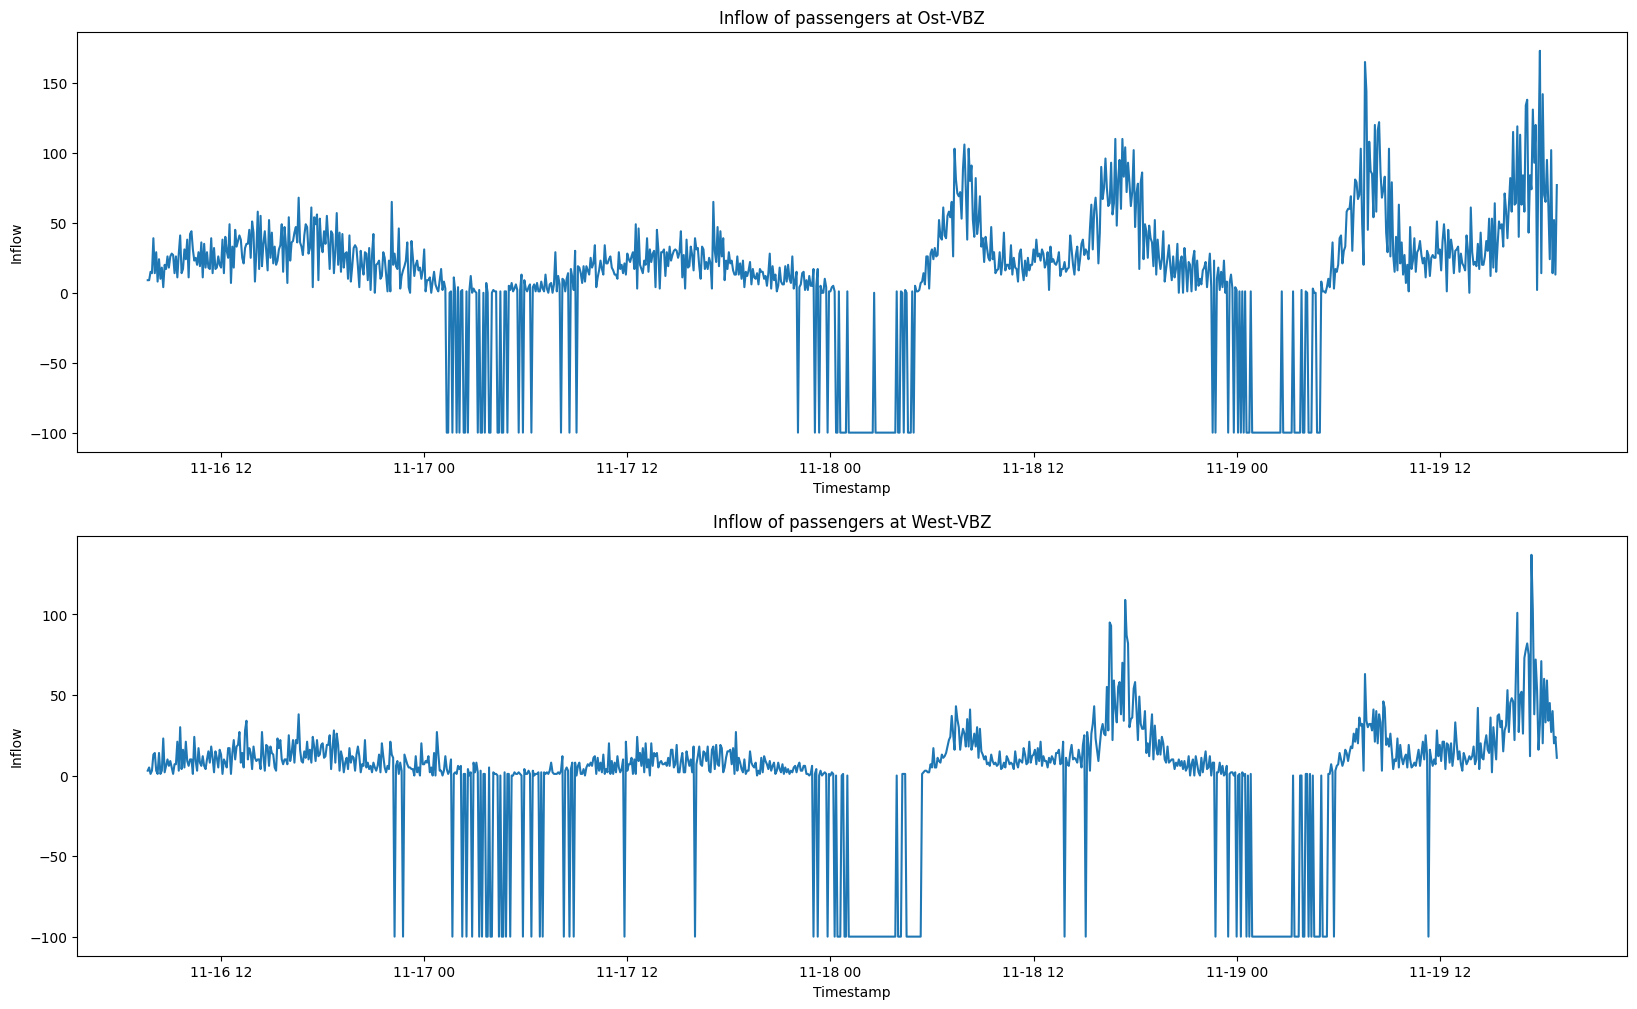

In [11]:
#Observe where missing values are located
healed_VBZ_mv = healed_VBZ.copy() #create a copy to work on
healed_VBZ_mv.fillna(-100, inplace = True) #Substitute missing values with negative value (impossible) in order to be able to identify them

#Plot the time series 
fig, axs = plt.subplots(2,1, figsize = (20, 12))
axs[0].plot(healed_VBZ_mv["Timestamp"].tail(1000), healed_VBZ_mv["Ost-VBZ Total"].tail(1000))
axs[0].set_xlabel("Timestamp")
axs[0].set_ylabel("Inflow")
axs[0].set_title("Inflow of passengers at Ost-VBZ")
axs[1].plot(healed_VBZ_mv["Timestamp"].tail(1000), healed_VBZ_mv["West-VBZ total"].tail(1000))
axs[1].set_xlabel("Timestamp")
axs[1].set_ylabel("Inflow")
axs[1].set_title("Inflow of passengers at West-VBZ")

### Dealing with missing values - Interpolation
Missing values seem to be distributed across the whole Timeseries and not concentrated in a single specific time interval. However, missing values seem to be appearing in a recurring pattern, with values missing regularly in the night hours comprised between 1 and 4 o' clock in the morning everyday. Despite this regularity, however, what happens at such an hour in the night isn't too relevant for the model prediction, since these hours where values are missing more often are typically hours during which there is no passengers in Hardbruecke. 

In order to obtain a cleaned Timeseries with equidistant observations, we can subsitute these missing values by interpolation, by taking the mean of the last and the next healthy datapoint available. Since we don't expect huge variations in the number of passengers occupying the station at such hours late in the night, the approximation should depict the reality faithfully enough.

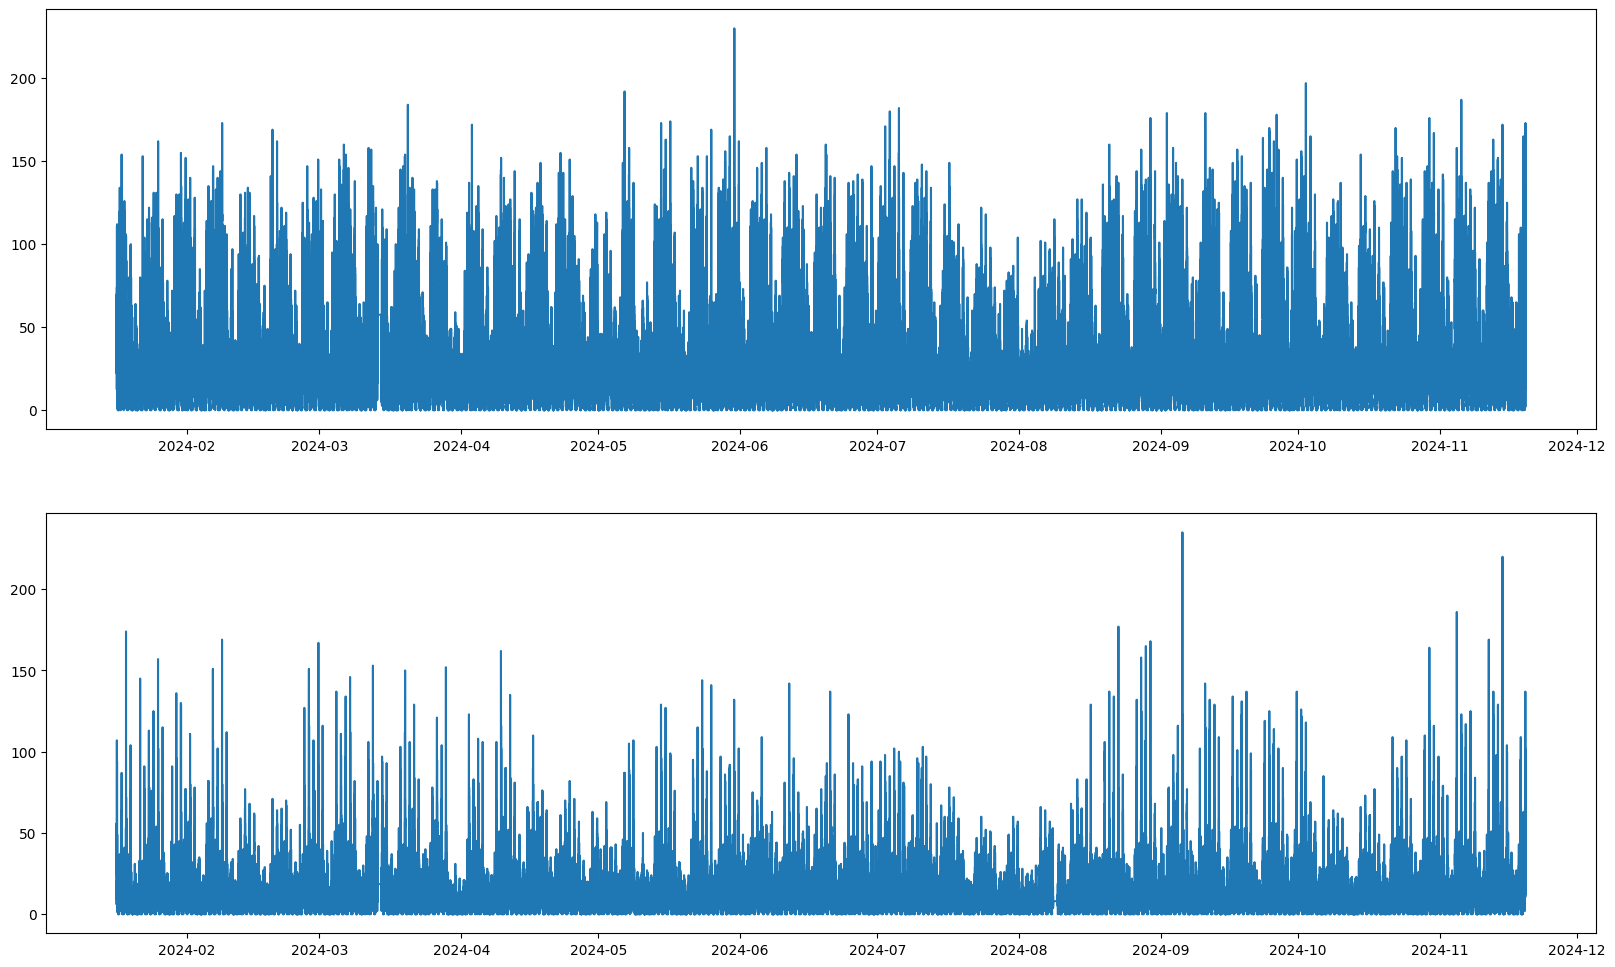

In [12]:
#Create columns with missing values substituted by interpolation, both by taking the value of the next healthy datapoint (forward fill)
# as well as by taking the value of the last available healthy datapoint (backward fill)
Ost_VBZ_Total_ff = healed_VBZ['Ost-VBZ Total'].ffill()
Ost_VBZ_Total_bf = healed_VBZ['Ost-VBZ Total'].bfill()

West_VBZ_total_ff = healed_VBZ['West-VBZ total'].ffill()
West_VBZ_total_bf = healed_VBZ['West-VBZ total'].bfill()

#Interpolate missing values by subsituting them by mean of forward and backward filling
healed_VBZ['Ost-VBZ Total'] = healed_VBZ['Ost-VBZ Total'].fillna((Ost_VBZ_Total_ff + Ost_VBZ_Total_bf) / 2)
healed_VBZ['West-VBZ total'] = healed_VBZ['West-VBZ total'].fillna((West_VBZ_total_ff + West_VBZ_total_bf) / 2)

#plot to see results
fig, axs = plt.subplots(2,1, figsize = (20, 12))
axs[0].plot(healed_VBZ["Timestamp"], healed_VBZ["Ost-VBZ Total"])
axs[1].plot(healed_VBZ["Timestamp"], healed_VBZ["West-VBZ total"])

### Cutting weather and VBZ datasets to let them have the same lenght

In [13]:
# Locate all observations after 16 january to match hardbrücke
#The hardbuecke Dataset has observations every five minutes starting from the 16th of January at 14:55
#Since we don't have data until the end of the current year yet, we can take all datapoints between 2024-01-16 14:55 and 2024-11-16 14:55
#to have exactly 10 months
healed_weather = healed_weather[healed_weather["Timestamp"] >= "2024-01-16 14:55:00"].reset_index(drop = True)
healed_weather = healed_weather[0:87841] #Cut healed_weather dataset for it to contain data from 16th of January 14:55 to the 16th of November 14:55
healed_VBZ = healed_VBZ[0:87841] #Do the same for healed_VBZ Dataset

#Check that the two datasets healed_weather and healed_VBZ have the same lenght
print(len(healed_VBZ) == len(healed_weather))

True


In [14]:
df

In  Out            Timestamp             Name
0        2    6  2024-01-16T14:55:00   Ost-Nord total
1       10   17  2024-01-16T14:55:00    Ost-SBB total
2        5    2  2024-01-16T14:55:00    Ost-Süd total
3       13    3  2024-01-16T14:55:00    Ost-VBZ Total
4        8    4  2024-01-16T14:55:00  West-Nord total
...     ..  ...                  ...              ...
620518  77   57  2024-11-19T18:55:00    Ost-VBZ Total
620519  22    9  2024-11-19T18:55:00  West-Nord total
620520  47   19  2024-11-19T18:55:00   West-SBB total
620521   2   14  2024-11-19T18:55:00   West-Süd total
620522  11   45  2024-11-19T18:55:00   West-VBZ total

[620523 rows x 4 columns]

### Adding dummy variable for holidays and variable fo day name

In [16]:
#Dummy for holidays
#Define which days of the years are holidays
feiertage = pd.DataFrame({
	"Date": ["2024-01-01", "2024-01-02", "2024-03-28", "2024-03-29", "2024-04-01", "2024-04-15", "2024-05-01", "2024-05-08", "2024-05-09",
              "2024-05-10", "2024-05-20", "2024-08-01", "2024-09-09", "2024-12-24", "2024-12-25", "2024-12-26", "2024-12-27", "2024-12-30",
              "2024-12-31"]
})

feiertage["Date"] = pd.to_datetime(feiertage["Date"])
#Add value 1 (True) for holidays
feiertage["Holiday"] = 1

In [17]:
# Create date range for 2024
dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")

# Create a dataframe with names of the days of the week
calendar = pd.DataFrame({
    "Date": dates,
    "Day": dates.day_name()  
})
#Convert date column into datetime format
calendar["Date"] = pd.to_datetime(calendar["Date"])

#Initially assign value 0 (False) under the Holiday feature for all observations
calendar["Holiday"] = 0

# Put value 1 (True) under the Holiday feature for observations that correspond to those ones of feiertage
calendar2 = np.where(calendar["Date"].isin(feiertage["Date"]), 1, 0)
calendar["Holiday"] = calendar2

#Consider weekends as holidays as as well 
calendar.loc[calendar["Day"].isin(["Saturday", "Sunday"]), "Holiday"] = 1

#Extract only Date and Holiday column from the calendar Dataframe, since these ones are the features that we want to integrate in our data
holiday_df = calendar[["Date", "Holiday"]]

#Extend healed_holiday to match granularity of healed_VBZ
def extend_holidays(holiday_df):
    # Create a list to hold the expanded data
    extended_df = []
    
    for _, row in holiday_df.iterrows():
        
        date = pd.Timestamp(row['Date']).date()
        holiday_value = row['Holiday']
        
        # Generate 5-minute intervals for the whole day
        time_range = pd.date_range(start=f"{date} 00:00:00", end=f"{date} 23:55:00", freq="5T")
        
        # Append each timestamp with the holiday value
        extended_df.extend([(timestamp, holiday_value) for timestamp in time_range])
    
    # Create a new DataFrame from the expanded data
    holiday_df_extended = pd.DataFrame(extended_df, columns=["Timestamp", "Holiday"])
    return holiday_df_extended

healed_holiday = extend_holidays(holiday_df)

#Cutting healed_holiday to have the same lenght as healed_VB
healed_holiday = healed_holiday[4499:92340]

#Merge healed_holiday with healed_VBZ
healed_VBZ = pd.merge(healed_VBZ, healed_holiday, on = "Timestamp", how = "inner")

C:\Users\kaito\AppData\Local\Temp\ipykernel_12512\3393714440.py:36: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start=f"{date} 00:00:00", end=f"{date} 23:55:00", freq="5T")


### Adding features for previous observations up to t-5

healed_VBZ.sort_values(by = "Timestamp",ascending=False, inplace = True)

#Add new variable for ost to shift values back
healed_VBZ["t-1 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-1)
healed_VBZ["t-2 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-2)
healed_VBZ["t-3 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-3)
healed_VBZ["t-4 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-4)
healed_VBZ["t-5 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-5)

#Add new variable for west to shift values back
healed_VBZ["t-1 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-1)
healed_VBZ["t-2 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-2)
healed_VBZ["t-3 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-3)
healed_VBZ["t-4 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-4)
healed_VBZ["t-5 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-5)

healed_VBZ.sort_values(by = "Timestamp",ascending=True, inplace = True)

In [18]:
healed_VBZ_ost = healed_VBZ.copy()
healed_VBZ_west = healed_VBZ.copy()

In [19]:
# Assuming healed_VBZ is your DataFrame and 'Timestamp' is in datetime format
healed_VBZ_ost.sort_values(by="Timestamp", ascending=False, inplace=True)

# Define the number of shifts (24 for a whole day)
num_shifts = 288

# Loop to create shifted columns for 'Ost-VBZ Total'
for i in range(1, num_shifts + 1):
    healed_VBZ_ost[f't{-i} Ost-VBZ'] = healed_VBZ_ost['Ost-VBZ Total'].shift(-i)

healed_VBZ_ost.sort_values(by="Timestamp", ascending=True, inplace=True)

healed_VBZ_west.sort_values(by="Timestamp", ascending=False, inplace=True)

# Loop to create shifted columns for 'West-VBZ total'
for i in range(1, num_shifts + 1):
    healed_VBZ_west[f't-{i} West-VBZ'] = healed_VBZ_west['West-VBZ total'].shift(-i)

healed_VBZ_west.sort_values(by="Timestamp", ascending=True, inplace=True)

C:\Users\kaito\AppData\Local\Temp\ipykernel_12512\3366477083.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  healed_VBZ_ost[f't{-i} Ost-VBZ'] = healed_VBZ_ost['Ost-VBZ Total'].shift(-i)
C:\Users\kaito\AppData\Local\Temp\ipykernel_12512\3366477083.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  healed_VBZ_ost[f't{-i} Ost-VBZ'] = healed_VBZ_ost['Ost-VBZ Total'].shift(-i)
C:\Users\kaito\AppData\Local\Temp\ipykernel_12512\3366477083.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

### Merging Datasets together

In [24]:
#Merge the two dataframes weather and hardbruecke (healed_weather and healed_VBZ)
data_ost = pd.merge(healed_VBZ_ost, healed_weather, on = "Timestamp", how = "inner")
data_west = pd.merge(healed_VBZ_west, healed_weather, on = "Timestamp", how = "inner")
#Now that we included previous obsevations' values as features (up to t-5), there are, of course, new missing values for the first 5 
#observations. There is no data for these missing values, since we built this dataset by taking the first available value of the year 
#2024 from the hardbruecke dataset. To avoid problems in the modelling phase, we therefore drop the fist 5 observations :(
data_ost = data_ost[data_ost["Timestamp"] >= "2024-01-18 00:00:00"]
data_ost = data_ost[data_ost["Timestamp"] <= "2024-11-15 23:55:00"]
data_west = data_west[data_west["Timestamp"] >= "2024-01-18 00:00:00"]
data_west = data_west[data_west["Timestamp"] <= "2024-11-15 23:55:00"]

In [25]:
data_west

Timestamp  Ost-VBZ Total  West-VBZ total  Holiday  \
397   2024-01-18 00:00:00            1.0             4.0        0   
398   2024-01-18 00:05:00            3.5             5.0        0   
399   2024-01-18 00:10:00            6.0             3.0        0   
400   2024-01-18 00:15:00            2.0             1.0        0   
401   2024-01-18 00:20:00            1.5             1.0        0   
...                   ...            ...             ...      ...   
87656 2024-11-15 23:35:00            1.0            16.0        0   
87657 2024-11-15 23:40:00           76.0             6.0        0   
87658 2024-11-15 23:45:00           26.0             9.0        0   
87659 2024-11-15 23:50:00           21.0             3.0        0   
87660 2024-11-15 23:55:00           18.0            12.0        0   

       t-1 West-VBZ  t-2 West-VBZ  t-3 West-VBZ  t-4 West-VBZ  t-5 West-VBZ  \
397             3.0           2.0           4.0           6.0           7.0   
398             4.0           3.0           2.0           4.0           6.0   
399             5.0           4.0           3.0           2.0           4.0   
400             3.0           5.0           4.0           3.0           2.0   
401             1.0           3.0           5.0           4.0           3.0   
...             ...           ...           ...           ...           ...   
87656           6.0           9.0          20.0          25.0          26.0   
87657          16.0           6.0           9.0          20.0          25.0   
87658           6.0          16.0           6.0           9.0          20.0   
87659           9.0           6.0          16.0           6.0           9.0   
87660           3.0           9.0           6.0          16.0           6.0   

       t-6 West-VBZ  ...  wind_speed_avg_10min  wind_force_avg_10min  \
397             5.5  ...                   4.0                   4.0   
398             7.0  ...                   4.0                   4.0   
399             6.0  ...                   3.8                   3.8   
400             4.0  ...                   3.8                   3.8   
401             2.0  ...                   4.3                   4.3   
...             ...  ...                   ...                   ...   
87656          50.0  ...                   1.6                   1.6   
87657          26.0  ...                   1.4                   1.4   
87658          25.0  ...                   1.4                   1.4   
87659          20.0  ...                   1.2                   1.2   
87660           9.0  ...                   1.2                   1.2   

       wind_direction  windchill  barometric_pressure_qfe  precipitation  \
397              55.0        6.0                    947.7            0.1   
398              55.0        6.0                    947.7            0.1   
399              50.0        6.1                    947.6            0.0   
400              50.0        6.1                    947.6            0.0   
401              63.0        5.8                    947.6            0.1   
...               ...        ...                      ...            ...   
87656           299.0        1.8                    978.2            0.0   
87657           307.0        2.1                    978.2            0.0   
87658           307.0        2.1                    978.2            0.0   
87659           297.0        2.1                    978.1            0.0   
87660           297.0        2.1                    978.1            0.0   

       dew_point  global_radiation  humidity  water_level  
397          7.3               0.0      86.0       405.83  
398          7.3               0.0      86.0       405.83  
399          7.3               0.0      86.0       405.84  
400          7.3               0.0      86.0       405.84  
401          7.2               0.0      87.0       405.84  
...          ...               ...       ...          ...  
87656        1.6               0.0      

Timestamp  Ost-VBZ Total  West-VBZ total  Holiday  \
397   2024-01-18 00:00:00            1.0             4.0        0   
398   2024-01-18 00:05:00            3.5             5.0        0   
399   2024-01-18 00:10:00            6.0             3.0        0   
400   2024-01-18 00:15:00            2.0             1.0        0   
401   2024-01-18 00:20:00            1.5             1.0        0   
...                   ...            ...             ...      ...   
87656 2024-11-15 23:35:00            1.0            16.0        0   
87657 2024-11-15 23:40:00           76.0             6.0        0   
87658 2024-11-15 23:45:00           26.0             9.0        0   
87659 2024-11-15 23:50:00           21.0             3.0        0   
87660 2024-11-15 23:55:00           18.0            12.0        0   

       t-1 Ost-VBZ  t-2 Ost-VBZ  t-3 Ost-VBZ  t-4 Ost-VBZ  t-5 Ost-VBZ  \
397            4.0          5.5          7.0         13.0          2.0   
398            1.0          4.0          5.5          7.0         13.0   
399            3.5          1.0          4.0          5.5          7.0   
400            6.0          3.5          1.0          4.0          5.5   
401            2.0          6.0          3.5          1.0          4.0   
...            ...          ...          ...          ...          ...   
87656          5.0         26.0         71.0         35.0          7.0   
87657          1.0          5.0         26.0         71.0         35.0   
87658         76.0          1.0          5.0         26.0         71.0   
87659         26.0         76.0          1.0          5.0         26.0   
87660         21.0         26.0         76.0          1.0          5.0   

       t-6 Ost-VBZ  ...  wind_speed_avg_10min  wind_force_avg_10min  \
397            5.0  ...                   4.0                   4.0   
398            2.0  ...                   4.0                   4.0   
399           13.0  ...                   3.8                   3.8   
400            7.0  ...                   3.8                   3.8   
401            5.5  ...                   4.3                   4.3   
...            ...  ...                   ...                   ...   
87656         60.0  ...                   1.6                   1.6   
87657          7.0  ...                   1.4                   1.4   
87658         35.0  ...                   1.4                   1.4   
87659         71.0  ...                   1.2                   1.2   
87660         26.0  ...                   1.2                   1.2   

       wind_direction  windchill  barometric_pressure_qfe  precipitation  \
397              55.0        6.0                    947.7            0.1   
398              55.0        6.0                    947.7            0.1   
399              50.0        6.1                    947.6            0.0   
400              50.0        6.1                    947.6            0.0   
401              63.0        5.8                    947.6            0.1   
...               ...        ...                      ...            ...   
87656           299.0        1.8                    978.2            0.0   
87657           307.0        2.1                    978.2            0.0   
87658           307.0        2.1                    978.2            0.0   
87659           297.0        2.1                    978.1            0.0   
87660           297.0        2.1                    978.1            0.0   

       dew_point  global_radiation  humidity  water_level  
397          7.3               0.0      86.0       405.83  
398          7.3               0.0      86.0       405.83  
399          7.3               0.0      86.0       405.84  
400          7.3               0.0      86.0       405.84  
401          7.2               0.0      87.0       405.84  
...          ...               ...       ...          ...  
87656        1.6               0.0      98.0       405.88  
87657        1.9               0.0      99.0       4

In [20]:
#do variable importance plot also
data_ost["Ost-VBZ Total"].corr(data_ost["water_level"])

np.float64(0.00450084745553999)

# Modelling phase - Random Forest

#Define Design matrix and outcome variables
y_ost = data["Ost-VBZ Total"]
y_west = data["West-VBZ total"]



exclude_columns_ost = ["Timestamp", 
                       "Ost-VBZ Total", 
                       "West-VBZ total", 
                       "t-1 West-VBZ", 
                       "t-2 West-VBZ", 
                       "t-3 West-VBZ", 
                       "t-4 West-VBZ", 
                       "t-5 West-VBZ"]
exclude_columns_west = ["Timestamp", 
                       "Ost-VBZ Total", 
                       "West-VBZ total", 
                       "t-1 Ost-VBZ", 
                       "t-2 Ost-VBZ", 
                       "t-3 Ost-VBZ", 
                       "t-4 Ost-VBZ", 
                       "t-5 Ost-VBZ"]

X_ost = data.drop(columns = exclude_columns_ost)
X_west = data.drop(columns = exclude_columns_west)
#Split into training and test data 
from sklearn.model_selection import train_test_split

X_ost_train, X_ost_test, y_ost_train, y_ost_test = train_test_split(X_ost, y_ost, shuffle = False, test_size = 0.2)
X_west_train, X_west_test, y_west_train, y_west_test = train_test_split(X_west, y_west, shuffle = False, test_size = 0.2)

In [29]:

#Define Design matrix and outcome variables
y_ost = data_ost["Ost-VBZ Total"]
y_west = data_west["West-VBZ total"]

exclude_columns_ost = ["Timestamp", 
                       "Ost-VBZ Total" ,
                       "West-VBZ total"
                       ]
exclude_columns_west = ["Timestamp", 
                       "West-VBZ total",
                       "Ost-VBZ Total" 
                       ]

X_ost = data_ost.drop(columns = exclude_columns_ost)
X_west = data_west.drop(columns = exclude_columns_west)
#Split into training and test data 
from sklearn.model_selection import train_test_split

threshold_train = 0.808580858085808580858085808580858085808580858085
threshold_test = 1- threshold_train

X_ost_train, X_ost_test, y_ost_train, y_ost_test = train_test_split(X_ost, y_ost, shuffle = False, test_size = threshold_test)
X_west_train, X_west_test, y_west_train, y_west_test = train_test_split(X_west, y_west, shuffle = False, test_size = threshold_test)

Holiday  t-1 Ost-VBZ  t-2 Ost-VBZ  t-3 Ost-VBZ  t-4 Ost-VBZ  \
70957        0         12.0          1.0          8.0         12.0   
70958        0          6.0         12.0          1.0          8.0   
70959        0          4.5          6.0         12.0          1.0   
70960        0          3.0          4.5          6.0         12.0   
70961        0          9.0          3.0          4.5          6.0   
...        ...          ...          ...          ...          ...   
87656        0          5.0         26.0         71.0         35.0   
87657        0          1.0          5.0         26.0         71.0   
87658        0         76.0          1.0          5.0         26.0   
87659        0         26.0         76.0          1.0          5.0   
87660        0         21.0         26.0         76.0          1.0   

       t-5 Ost-VBZ  t-6 Ost-VBZ  t-7 Ost-VBZ  t-8 Ost-VBZ  t-9 Ost-VBZ  ...  \
70957          3.0         11.0          3.0         17.0         10.0  ...   
70958         12.0          3.0         11.0          3.0         17.0  ...   
70959          8.0         12.0          3.0         11.0          3.0  ...   
70960          1.0          8.0         12.0          3.0         11.0  ...   
70961         12.0          1.0          8.0         12.0          3.0  ...   
...            ...          ...          ...          ...          ...  ...   
87656          7.0         60.0          2.0         77.0          3.0  ...   
87657         35.0          7.0         60.0          2.0         77.0  ...   
87658         71.0         35.0          7.0         60.0          2.0  ...   
87659         26.0         71.0         35.0          7.0         60.0  ...   
87660          5.0         26.0         71.0         35.0          7.0  ...   

       wind_speed_avg_10min  wind_force_avg_10min  wind_direction  windchill  \
70957                   0.8                   0.8           267.0       11.9   
70958                   0.8                   0.8           267.0       11.9   
70959                   0.9                   0.9           237.0       12.0   
70960                   0.9                   0.9           237.0       12.0   
70961                   1.5                   1.5           272.0       11.8   
...                     ...                   ...             ...        ...   
87656                   1.6                   1.6           299.0        1.8   
87657                   1.4                   1.4           307.0        2.1   
87658                   1.4                   1.4           307.0        2.1   
87659                   1.2                   1.2           297.0        2.1   
87660                   1.2                   1.2           297.0        2.1   

       barometric_pressure_qfe  precipitation  dew_point  global_radiation  \
70957                    971.7            0.0       11.1               0.0   
70958                    971.7            0.0       11.1               0.0   
70959                    971.7            0.0       11.1               0.0   
70960                    971.7            0.0       11.1               0.0   
70961                    971.7            0.0       11.0               0.0   
...                        ...            ...        ...               ...   
87656                    978.2            0.0        1.6               0.0   
87657                    978.2            0.0        1.9               0.0   
87658                    978.2            0.0        1.9               0.0   
87659                    978.1            0.0        1.7               0.0   
87660                    978.1            0.0        1.7               0.0   

       humidity  water_level  
70957      95.0       406.00  
70958      95.0       406.00  
70959      95.0       406.00  
70960      95.0       406.00  
70961      95.0       406.00  
...         ...          ...  
87656      98.0       405.88  
87657      99.0       405.88  
87658      99.0       405.88  
87659    

### Predicting inflow of passengers in Ost

In [25]:
#Import RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor

RF_ost = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72 )

#Train RandomForest Regressor for Ost 
RF_ost.fit(X_ost_train, y_ost_train)

#Predict for train set
y_ost_predict_train = RF_ost.predict(X_ost_train)
y_ost_predict_test = RF_ost.predict(X_ost_test)

# Import the mean_squared_error function under the alias mse
from sklearn.metrics import mean_squared_error as mse

#Show MSE
print("Ost Train MSE:", mse(y_ost_train, y_ost_predict_train))
print("Ost Test MSE:", mse(y_ost_test, y_ost_predict_test))

Ost Train MSE: 21.59145737026338
Ost Test MSE: 165.89014462853297


In [26]:
RF_west = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72)

#Train RandomForest Regressor for West
RF_west.fit(X_west_train, y_west_train)

#Predict for train and test sets
y_west_predict_train = RF_west.predict(X_west_train)
y_west_predict_test = RF_west.predict(X_west_test)

#Show MSE
print("West Train MSE:", mse(y_west_train, y_west_predict_train))
print("West Test MSE:", mse(y_west_test, y_west_predict_test))

West Train MSE: 7.27738237496923
West Test MSE: 52.78437454209139


Text(0, 0.5, 'Predicted Value')

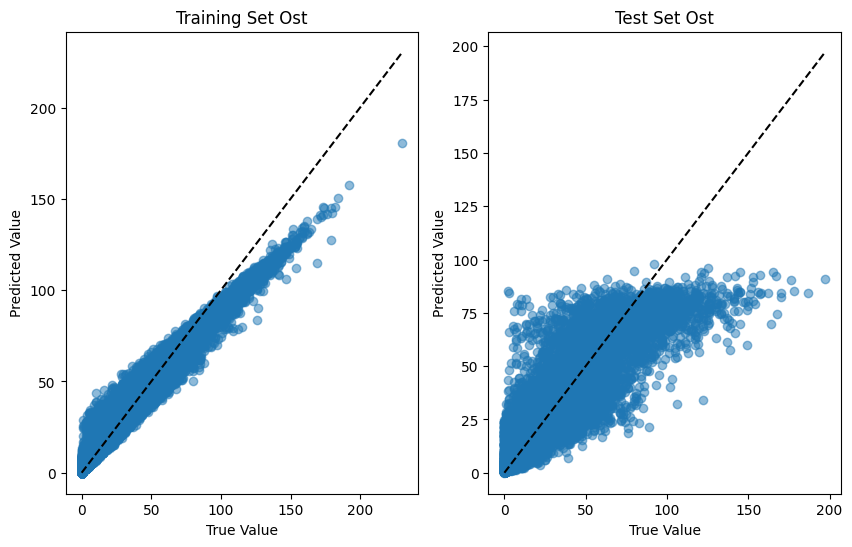

In [30]:
# Plot our predictions for Ost data
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot the training data Ost
axs[0].scatter(y_ost_train, y_ost_predict_train, alpha=0.5, label="train")
# Plot a diagonal line
axs[0].plot(*[[np.minimum(y_ost_train.min(), y_ost_predict_train.min()), 
               np.maximum(y_ost_train.max(), y_ost_predict_train.max())] for _ in range(2)],
              color = "black", ls="--")
axs[0].set_title("Training Set Ost")
axs[0].set_xlabel("True Value")
axs[0].set_ylabel("Predicted Value")

# Plot the test data Ost
axs[1].scatter(y_ost_test, y_ost_predict_test, alpha=0.5, label="test")
# Plot a diagonal line
axs[1].plot(*[[np.minimum(y_ost_test.min(), y_ost_predict_test.min()), 
               np.maximum(y_ost_test.max(), y_ost_predict_test.max())] for _ in range(2)],
              color = "black", ls="--")
axs[1].set_title("Test Set Ost")
axs[1].set_xlabel("True Value")
axs[1].set_ylabel("Predicted Value")

### Feature Importance Plot to assess which variables should be droped


In [27]:
def plot_variable_importance(model, X_train):
    # Create a DataFrame with the feature importance of the model
    imp = pd.DataFrame({"imp": model.feature_importances_, "names": X_train.columns}).sort_values(by="imp", ascending=True)
    fig, ax = plt.subplots(figsize= (imp.shape[0]/6,imp.shape[0]/5), dpi = 300)
    
    
    # Plot the feature importance
    ax.barh(imp["names"], imp["imp"], color = "skyblue")
    ax.set_xlabel("\nFeature Importance")
    ax.set_ylabel("Features\n")
    ax.set_title("Variable Importance\n")
    plt.show()
    

We can see that after windchill there is a slight  drop off in variable importance, thus we cut of the variables which are below. We keep the t- variables even tough they explain the data less than some weather variables as to keep the seasonality and equidistance in tact. The above ones have a pretty high importance. Especially global_radiation which makes sense, as with more sun people tend to go outside more often. Precipitation could be so low, because the people have no alternative to taking public transport even though its raining. Maybe commuting by bike is just not an option in zürich.

In [28]:
plot_variable_importance(RF_ost, X_ost_train)

In [28]:
#See with numbers how important each feature is
gedöns = pd.DataFrame({"imp": RF_ost.feature_importances_, "names": X_ost_train.columns}).sort_values(by="imp", ascending=True)
gedöns[gedöns["imp"] < 0.002]
drop = gedöns[gedöns["imp"] < 0.002]
drop_list_ost = drop["names"].to_list()

gedöns = pd.DataFrame({"imp": RF_west.feature_importances_, "names": X_west_train.columns}).sort_values(by="imp", ascending=True)
gedöns[gedöns["imp"] < 0.002]
drop = gedöns[gedöns["imp"] < 0.002]
drop_list_west = drop["names"].to_list()


NameError: name 'RF_ost' is not defined

In [ ]:
#Drop the variables which are not needed variant 2 with only graphical analysis
drop_columns_weather = ["Timestamp","Ost-VBZ Total" ,"West-VBZ total"]

#Define Design matrix and outcome variables
y_ost = data_ost["Ost-VBZ Total"]
y_west = data_west["West-VBZ total"]


X_ost_reduced = data_ost.drop(columns = drop_columns_weather)
X_ost_reduced.drop(columns = drop_list, inplace = True)
X_west_reduced = data_west.drop(columns =  drop_columns_weather)
X_west_reduced.drop(columns = drop_list, inplace = True)
#Split into training and test data 
from sklearn.model_selection import train_test_split

X_ost_train_reduced, X_ost_test_reduced, y_ost_train, y_ost_test = train_test_split(X_ost_reduced, y_ost, shuffle = False, test_size = 0.2)
X_west_train_reduced, X_west_test_reduced, y_west_train, y_west_test = train_test_split(X_west_reduced, y_west, shuffle = False, test_size = 0.2)

KeyError: "['t-198 Ost-VBZ', 't-199 Ost-VBZ', 't-197 Ost-VBZ', 't-203 Ost-VBZ', 't-193 Ost-VBZ', 't-191 Ost-VBZ', 't-200 Ost-VBZ', 't-211 Ost-VBZ', 't-202 Ost-VBZ', 't-205 Ost-VBZ', 't-206 Ost-VBZ', 't-196 Ost-VBZ', 't-194 Ost-VBZ', 't-187 Ost-VBZ', 't-208 Ost-VBZ', 't-207 Ost-VBZ', 't-209 Ost-VBZ', 't-186 Ost-VBZ', 't-201 Ost-VBZ', 't-214 Ost-VBZ', 't-89 Ost-VBZ', 't-210 Ost-VBZ', 't-87 Ost-VBZ', 't-217 Ost-VBZ', 't-91 Ost-VBZ', 't-220 Ost-VBZ', 't-228 Ost-VBZ', 't-212 Ost-VBZ', 't-213 Ost-VBZ', 't-69 Ost-VBZ', 't-92 Ost-VBZ', 't-146 Ost-VBZ', 't-226 Ost-VBZ', 't-222 Ost-VBZ', 't-93 Ost-VBZ', 't-188 Ost-VBZ', 't-88 Ost-VBZ', 't-86 Ost-VBZ', 't-216 Ost-VBZ', 't-241 Ost-VBZ', 't-95 Ost-VBZ', 't-78 Ost-VBZ', 't-218 Ost-VBZ', 't-231 Ost-VBZ', 't-83 Ost-VBZ', 't-219 Ost-VBZ', 't-215 Ost-VBZ', 't-192 Ost-VBZ', 't-90 Ost-VBZ', 't-84 Ost-VBZ', 't-204 Ost-VBZ', 't-136 Ost-VBZ', 't-140 Ost-VBZ', 't-144 Ost-VBZ', 't-234 Ost-VBZ', 't-81 Ost-VBZ', 't-130 Ost-VBZ', 't-159 Ost-VBZ', 't-235 Ost-VBZ', 't-139 Ost-VBZ', 't-133 Ost-VBZ', 't-238 Ost-VBZ', 't-94 Ost-VBZ', 't-134 Ost-VBZ', 't-221 Ost-VBZ', 't-225 Ost-VBZ', 't-232 Ost-VBZ', 't-224 Ost-VBZ', 't-77 Ost-VBZ', 't-85 Ost-VBZ', 't-227 Ost-VBZ', 't-80 Ost-VBZ', 't-82 Ost-VBZ', 't-229 Ost-VBZ', 't-223 Ost-VBZ', 't-96 Ost-VBZ', 't-233 Ost-VBZ', 't-230 Ost-VBZ', 't-152 Ost-VBZ', 't-240 Ost-VBZ', 't-143 Ost-VBZ', 't-73 Ost-VBZ', 't-237 Ost-VBZ', 't-129 Ost-VBZ', 't-138 Ost-VBZ', 't-155 Ost-VBZ', 't-190 Ost-VBZ', 't-97 Ost-VBZ', 't-189 Ost-VBZ', 't-135 Ost-VBZ', 't-172 Ost-VBZ', 't-74 Ost-VBZ', 't-59 Ost-VBZ', 't-68 Ost-VBZ', 't-254 Ost-VBZ', 't-145 Ost-VBZ', 't-239 Ost-VBZ', 't-66 Ost-VBZ', 't-72 Ost-VBZ', 't-56 Ost-VBZ', 't-261 Ost-VBZ', 't-151 Ost-VBZ', 't-154 Ost-VBZ', 't-183 Ost-VBZ', 't-142 Ost-VBZ', 't-67 Ost-VBZ', 't-79 Ost-VBZ', 't-149 Ost-VBZ', 't-75 Ost-VBZ', 't-60 Ost-VBZ', 't-132 Ost-VBZ', 't-246 Ost-VBZ', 't-65 Ost-VBZ', 't-58 Ost-VBZ', 't-262 Ost-VBZ', 't-236 Ost-VBZ', 't-99 Ost-VBZ', 't-244 Ost-VBZ', 't-131 Ost-VBZ', 't-157 Ost-VBZ', 't-148 Ost-VBZ', 't-243 Ost-VBZ', 't-242 Ost-VBZ', 't-141 Ost-VBZ', 't-147 Ost-VBZ', 't-64 Ost-VBZ', 't-252 Ost-VBZ', 't-250 Ost-VBZ', 't-195 Ost-VBZ', 't-255 Ost-VBZ', 't-158 Ost-VBZ', 't-256 Ost-VBZ', 't-245 Ost-VBZ', 't-264 Ost-VBZ', 't-23 Ost-VBZ', 't-161 Ost-VBZ', 't-247 Ost-VBZ', 't-260 Ost-VBZ', 't-263 Ost-VBZ', 't-163 Ost-VBZ', 't-253 Ost-VBZ', 't-162 Ost-VBZ', 't-268 Ost-VBZ', 't-137 Ost-VBZ', 't-258 Ost-VBZ', 't-164 Ost-VBZ', 't-153 Ost-VBZ', 't-165 Ost-VBZ', 't-25 Ost-VBZ', 't-251 Ost-VBZ', 't-124 Ost-VBZ', 't-248 Ost-VBZ', 't-70 Ost-VBZ', 't-175 Ost-VBZ', 't-176 Ost-VBZ', 't-249 Ost-VBZ', 't-26 Ost-VBZ', 't-128 Ost-VBZ', 't-156 Ost-VBZ', 't-100 Ost-VBZ', 't-61 Ost-VBZ', 't-167 Ost-VBZ', 't-27 Ost-VBZ', 't-266 Ost-VBZ', 't-160 Ost-VBZ', 't-62 Ost-VBZ', 't-63 Ost-VBZ', 't-127 Ost-VBZ', 't-259 Ost-VBZ', 't-173 Ost-VBZ', 't-30 Ost-VBZ', 't-28 Ost-VBZ', 't-257 Ost-VBZ', 't-170 Ost-VBZ', 't-76 Ost-VBZ', 't-98 Ost-VBZ', 't-150 Ost-VBZ', 't-101 Ost-VBZ', 't-185 Ost-VBZ', 't-31 Ost-VBZ', 't-180 Ost-VBZ', 't-71 Ost-VBZ', 't-174 Ost-VBZ', 't-54 Ost-VBZ', 't-121 Ost-VBZ', 't-184 Ost-VBZ', 't-29 Ost-VBZ', 't-32 Ost-VBZ', 't-126 Ost-VBZ', 't-33 Ost-VBZ', 't-102 Ost-VBZ', 't-265 Ost-VBZ', 't-45 Ost-VBZ', 't-55 Ost-VBZ', 't-103 Ost-VBZ', 't-49 Ost-VBZ', 't-24 Ost-VBZ', 't-51 Ost-VBZ', 't-20 Ost-VBZ', 't-34 Ost-VBZ', 't-22 Ost-VBZ', 't-52 Ost-VBZ', 't-53 Ost-VBZ', 't-125 Ost-VBZ', 't-43 Ost-VBZ', 't-271 Ost-VBZ'] not found in axis"

In [64]:
drop_columns_weather

['Timestamp',
 'Ost-VBZ Total',
 'West-VBZ total',
 297    precipitation
 198    t-198 Ost-VBZ
 199    t-199 Ost-VBZ
 197    t-197 Ost-VBZ
 203    t-203 Ost-VBZ
            ...      
 52      t-52 Ost-VBZ
 53      t-53 Ost-VBZ
 125    t-125 Ost-VBZ
 43      t-43 Ost-VBZ
 271    t-271 Ost-VBZ
 Name: names, Length: 219, dtype: object]

In [ ]:
#Drop the variables which are not needed variant 2 with only graphical analysis
drop_columns_weather = ["Timestamp","Ost-VBZ Total" ,"West-VBZ total", "barometric_pressure_qfe", "dew_point", "wind_direction", "humidity", "wind_gust_max_10min", "water_temperature", "water_level", "wind_speed_avg_10min", "wind_force_avg_10min", "precipitation"]

#Define Design matrix and outcome variables
y_ost = data_ost["Ost-VBZ Total"]
y_west = data_west["West-VBZ total"]


X_ost_reduced = data_ost.drop(columns = drop_columns_weather)
X_west_reduced = data_west.drop(columns =  drop_columns_weather)
#Split into training and test data 
from sklearn.model_selection import train_test_split

X_ost_train_reduced, X_ost_test_reduced, y_ost_train, y_ost_test = train_test_split(X_ost_reduced, y_ost, shuffle = False, test_size = 0.2)
X_west_train_reduced, X_west_test_reduced, y_west_train, y_west_test = train_test_split(X_west_reduced, y_west, shuffle = False, test_size = 0.2)

### Performance of reduced model

In [50]:
RF_ost_reduced = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72 )

#Train RandomForest Regressor for Ost 
RF_ost_reduced.fit(X_ost_train_reduced, y_ost_train)

#Predict for train set
y_ost_predict_train_reduced = RF_ost_reduced.predict(X_ost_train_reduced)
y_ost_predict_test_reduced = RF_ost_reduced.predict(X_ost_test_reduced)



#Show MSE
print("Ost Train MSE:", mse(y_ost_train, y_ost_predict_train_reduced))
print("Ost Test MSE:", mse(y_ost_test, y_ost_predict_test_reduced))

Ost Train MSE: 21.501422973860823
Ost Test MSE: 165.49831394358856


In [ ]:
RF_west_reduced = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72 )

#Train RandomForest Regressor for Ost 
RF_west_reduced.fit(X_west_train_reduced, y_west_train)

#Predict for train set
y_west_predict_train_reduced = RF_west_reduced.predict(X_west_train_reduced)
y_west_predict_test_reduced = RF_west_reduced.predict(X_west_test_reduced)



#Show MSE
print("West Train MSE:", mse(y_west_train, y_west_predict_train_reduced))
print("West Test MSE:", mse(y_west_test, y_west_predict_test_reduced))

### Performance of the RandomForest
Letting a RandomForest algorithm run withough tuning any parameter leads to estimations that might not be too accurate. 
- For the Bus Stop Hardbruecke with direction Schiffbau (Ost) the RandomForest performs somewhat decently (MSE = 25,6) in the trainset but very poorly in the test set (MSE = 206,14).
- FOR THE Bus Stop Hardbruecke with direction with direction Hardplatz the RandomForest performs far better. The MSE for the predictions on the Training set is 9,51 and for the Test set is about 82,27.

In both cases, the MSE is severely higher for the Testset, hinting towards an overfitting of the model. We can tune the hyperparamters of the model to try achieve a better estimate.

Text(0.5, 1.0, 'Test Set Ost')

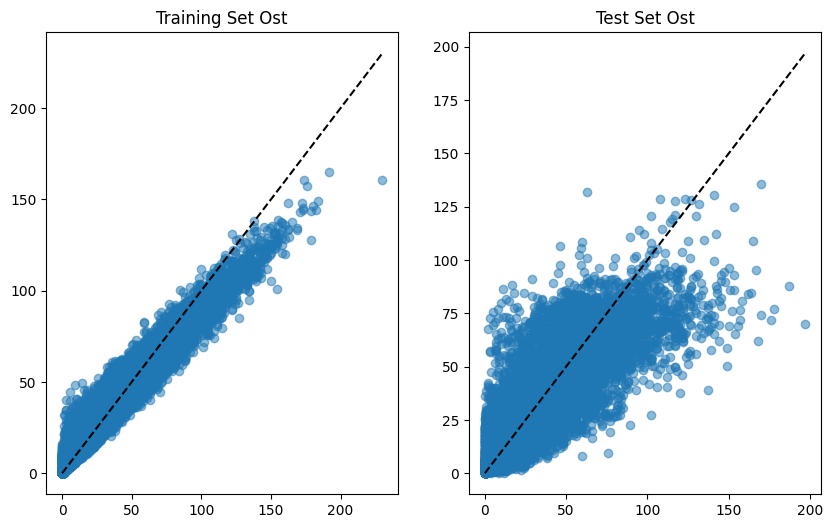

In [25]:
# Plot our predictions for Ost data
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot the training data Ost
axs[0].scatter(y_ost_train, y_ost_predict_train, alpha=0.5, label="train")
# Plot a diagonal line
axs[0].plot(*[[np.minimum(y_ost_train.min(), y_ost_predict_train.min()), 
               np.maximum(y_ost_train.max(), y_ost_predict_train.max())] for _ in range(2)],
              color = "black", ls="--")
axs[0].set_title("Training Set Ost")

# Plot the test data Ost
axs[1].scatter(y_ost_test, y_ost_predict_test, alpha=0.5, label="test")
# Plot a diagonal line
axs[1].plot(*[[np.minimum(y_ost_test.min(), y_ost_predict_test.min()), 
               np.maximum(y_ost_test.max(), y_ost_predict_test.max())] for _ in range(2)],
              color = "black", ls="--")
axs[1].set_title("Test Set Ost")

### Hyperparameter tuning of the RandomForest

In [28]:
 # Run random forest again by setting max_feature = "sqrt"
RF_ost_t = RandomForestRegressor(n_estimators = 500, max_features = "sqrt", random_state = 72)

#Train RandomForest on Training Set for Ost
RF_ost_t.fit(X_ost_train, y_ost_train)

#Predict for train and test set
y_ost_pred_train = RF_ost_t.predict(X_ost_train)
y_ost_pred_test = RF_ost_t.predict(X_ost_test)

#Show MSE
print("Ost Train MSE:", mse(y_ost_train, y_ost_pred_train))
print("Ost Test MSE:", mse(y_ost_test, y_ost_pred_test))

Ost Train MSE: 24.213658031042584
Ost Test MSE: 195.3343778978642


In [64]:
RF_west_t = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72)

#Train RandomForest on Training Set for west
RF_west_t.fit(X_west_train, y_west_train)

#Preidct for train and test sets
y_west_pred_train = RF_west_t.predict(X_west_train)
y_west_pred_test = RF_west_t.predict(X_west_test)

#Show MSE
print("West Train MSE:", mse(y_west_train, y_west_pred_train))
print("West Test MSE:", mse(y_west_test, y_west_pred_test))

West Train MSE: 7.324454273543721
West Test MSE: 54.05539064563303


In [114]:
hallo = X_ost_train.copy()

hallo.insert(0, "Mamamialol", y_west_train)
X_west_train
X_ost_train[:1]
X_ost_train.iloc[:, 287]





288      13.0
289      14.0
290      29.0
291      18.0
292      33.0
         ... 
69346    20.0
69347    25.0
69348    15.0
69349    25.0
69350    23.0
Name: t-288 Ost-VBZ, Length: 69063, dtype: float64

# Nested Random Forest Predictions

In [140]:
#Shift holiday variable to the right as to not interfere below
X_west_train = X_west_train.assign(Holiday=X_west_train.pop('Holiday'))
X_ost_train = X_ost_train.assign(Holiday=X_ost_train.pop('Holiday'))

X_west_test = X_west_test.assign(Holiday=X_west_test.pop('Holiday'))
X_ost_test = X_ost_test.assign(Holiday=X_ost_test.pop('Holiday'))
#Reset index of X_west_train and X_ost_train to 0 to properly index below
X_west_train = X_west_train.reset_index().drop(columns = "index")
X_ost_train = X_ost_train.reset_index().drop(columns = "index")

X_west_test = X_west_test.reset_index().drop(columns = "index")
X_ost_test = X_ost_test.reset_index().drop(columns = "index")

In [154]:
#this one is just to test some stuff

X_ost_train
X_ost_train.iloc[0,:]
X_ost_train[:289]
wallah = X_ost_train.copy()
wallah.reset_index().drop(columns = "index")
X_ost_train
X_ost_test
X_ost_train.iloc[1]
range(0, min(288, len(X_ost_train)))
len(X_ost_train)
X_ost_train.iloc[288]

t-1 Ost-VBZ          11.00
t-2 Ost-VBZ          37.00
t-3 Ost-VBZ          15.00
t-4 Ost-VBZ          16.00
t-5 Ost-VBZ          33.00
                     ...  
dew_point             7.20
global_radiation     19.00
humidity             74.00
water_level         405.85
Holiday               0.00
Name: 288, Length: 302, dtype: float64

In [ ]:

results_train = []
results_test = []
#Predict for train and test set
for i in range(0,288):
    y_ost_pred_train = RF_ost_t.predict(X_ost_train.iloc[i])
    y_ost_pred_test = RF_ost_t.predict(X_ost_test)
    X_ost_train.insert(0, [f"t +{i}" ],  y_ost_pred_train)
    X_ost_train.drop(X_ost_train.iloc[:, 287], inplace = True)
    results_train.append(y_ost_pred_train)   
    results_test.append(y_ost_pred_test)
             
#Show MSE
print("Ost Train MSE:", mse(y_ost_train, results_train))
print("Ost Test MSE:", mse(y_ost_test, results_test))

IndexError: list index out of range